In [279]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import altair as alt
alt.data_transformers.disable_max_rows()
alt.display.renderers.enable('svg')
import matplotlib.pyplot as plt

import act
import act.discovery, act.io

import metpy.calc, metpy.constants
from metpy.units import units
import glob
from tqdm import tqdm
from sublimpy import utils
import datetime as dt

In [280]:
startdate = "2022-11-30"
enddate = "2023-06-20"

In [281]:
data_dir = "/Users/elischwat/Development/data/sublimationofsnow/"
# for SAIL data queries
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")
DATE_FORMAT_STR = '%Y-%m-%d'

In [282]:
sos_fn = '../paper1/process_slow_data/tidy_df_20221101_20230619_planar_fit_multiplane_q7_flags9000_pf10.parquet'
sos_df = pd.read_parquet(sos_fn)

# Examine synoptic winds, with doppler lidar (PPI/VAD)

### Open files

In [283]:
SAIL_DATA_STREAM = 'gucdlprofwind4newsM1.c1'
DATA_STREAM_FILEEXT = '.nc'
output_dir = os.path.join("/Users/elischwat/Development/data/sublimationofsnow/", SAIL_DATA_STREAM)

In [284]:
# act.discovery.download_arm_data(username, token, SAIL_DATA_STREAM, startdate, enddate, output=output_dir)

In [285]:
dl_w_prof_files = glob.glob("/Users/elischwat/Development/data/sublimationofsnow/gucdlprofwind4newsM1.c1/*.nc")

In [286]:
prof_ds = act.io.read_arm_netcdf(dl_w_prof_files[0:1000])
prof_ds.time.min(), prof_ds.time.max()

(<xarray.DataArray 'time' ()> Size: 8B
 array('2022-11-30T00:00:39.646250000', dtype='datetime64[ns]'),
 <xarray.DataArray 'time' ()> Size: 8B
 array('2023-06-15T23:59:20.789108000', dtype='datetime64[ns]'))

In [287]:
prof_df = prof_ds.to_dataframe()
prof_df_localtime = utils.modify_df_timezone(prof_df.reset_index(), 'UTC', 'US/Mountain').set_index('time')

# Calculate mean synoptic winds, gap fill, calculate statistics for how much good data there is

## Use DL PPI Profile data

In [288]:
synoptic_winds_30min = prof_df_localtime.query("height >= 1000").query("height <= 1500")[
    ['wind_speed', 'wind_direction']
].reset_index().set_index('time').groupby(
    pd.Grouper(freq='30min')
).apply(lambda g: g.mean(skipna=True))

In [289]:
len(synoptic_winds_30min.ffill(limit=6)), len(synoptic_winds_30min.ffill(limit=6).dropna())

(9506, 6732)

In [290]:
synoptic_winds_30min = synoptic_winds_30min.ffill(limit=6)

In [291]:
len(synoptic_winds_30min), len(synoptic_winds_30min.dropna())

(9506, 6732)

In [292]:
synoptic_winds_15min = prof_df_localtime.query("height >= 1000").query("height <= 1500")[
    ['wind_speed', 'wind_direction']
].reset_index().groupby('time').apply(lambda g: g.mean(skipna=True))
synoptic_winds_15min_filled = synoptic_winds_15min.ffill(limit=12).bfill(limit=1)
synoptic_winds_30min = synoptic_winds_15min_filled.groupby(
    pd.Grouper(freq='30min')
).apply(lambda g: g.mean(skipna=True))

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_92909/276061567.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ].reset_index().groupby('time').apply(lambda g: g.mean(skipna=True))


In [293]:
len(synoptic_winds_30min), len(synoptic_winds_30min.dropna())

(9506, 6817)

## Use Rawinsonde data to fill gaps, using rawinsondes to apply for +/- 3 hours on either side of the release time

### Download/open data

In [294]:
sonde_data_code = 'gucsondewnpnM1.b1'

In [295]:
# # Download the data
# files = act.discovery.download_arm_data(
#     username,
#     token,
#     sonde_data_code,
#     startdate,
#     enddate,
#     output = os.path.join(data_dir, sonde_data_code)
# )
# files = sorted(files)

URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>

In [296]:
files = sorted(glob.glob(os.path.join(data_dir, sonde_data_code, f"*.cdf")))

In [297]:
sondes_ds = xr.open_mfdataset(files)
sondes_df = sondes_ds.to_dataframe().reset_index()
sondes_df = utils.modify_df_timezone(sondes_df, 'UTC', 'US/Mountain')
sondes_df['date'] = sondes_df.time.dt.date.astype(str)
sondes_df['hour'] = sondes_df.time.dt.hour
sondes_df['timeofday'] = (sondes_df['hour'] < 12).apply(lambda is_morning: 'Morning' if is_morning else 'Afternoon')
sondes_df['height'] = sondes_df['alt'] - 2891

In [298]:
sondes_df = sondes_df.query("height >= 1000").query("height <= 1500").groupby(['date', 'timeofday']).mean()[['wspd', 'deg']].rename(
    columns={'wspd': 'wind_speed', 'deg': 'wind_direction'}
)

In [299]:
import datetime as dt

In [300]:
sondes_df['datetime'] =  pd.to_datetime(sondes_df.reset_index().apply(
    lambda row: dt.datetime(
        pd.to_datetime(row['date']).year,
        pd.to_datetime(row['date']).month,
        pd.to_datetime(row['date']).day,
        hour=4,
        minute=30
    ) if row['timeofday'] == 'Morning'
    else
    dt.datetime(
        pd.to_datetime(row['date']).year,
        pd.to_datetime(row['date']).month,
        pd.to_datetime(row['date']).day,
        hour=16,
        minute=30
    ),
    axis=1
)).values

### create new rows so the rawinsonde measurement is there for +/- 3 hours around the time of release

In [301]:
cols = ['wind_speed',	'wind_direction', 'datetime']
sondes_df = pd.concat([
    sondes_df.reset_index()[cols],
    sondes_df.assign(datetime = sondes_df['datetime'] + dt.timedelta(minutes=30)).reset_index()[cols],
    sondes_df.assign(datetime = sondes_df['datetime'] + dt.timedelta(minutes=60)).reset_index()[cols],
    sondes_df.assign(datetime = sondes_df['datetime'] + dt.timedelta(minutes=90)).reset_index()[cols],
    sondes_df.assign(datetime = sondes_df['datetime'] + dt.timedelta(minutes=120)).reset_index()[cols],
    sondes_df.assign(datetime = sondes_df['datetime'] + dt.timedelta(minutes=150)).reset_index()[cols],
    sondes_df.assign(datetime = sondes_df['datetime'] + dt.timedelta(minutes=180)).reset_index()[cols],
    sondes_df.assign(datetime = sondes_df['datetime'] - dt.timedelta(minutes=30)).reset_index()[cols],
    sondes_df.assign(datetime = sondes_df['datetime'] - dt.timedelta(minutes=60)).reset_index()[cols],
    sondes_df.assign(datetime = sondes_df['datetime'] - dt.timedelta(minutes=90)).reset_index()[cols],
    sondes_df.assign(datetime = sondes_df['datetime'] - dt.timedelta(minutes=120)).reset_index()[cols],
    sondes_df.assign(datetime = sondes_df['datetime'] - dt.timedelta(minutes=150)).reset_index()[cols],
    sondes_df.assign(datetime = sondes_df['datetime'] - dt.timedelta(minutes=180)).reset_index()[cols],
]).set_index('datetime').sort_index()

### fill gaps

In [302]:
synoptic_winds_30min_filledwithradiosondes = synoptic_winds_30min.copy()
synoptic_winds_30min_filledwithradiosondes['wind_speed'] = synoptic_winds_30min_filledwithradiosondes['wind_speed'].fillna(
    sondes_df['wind_speed']
)
synoptic_winds_30min_filledwithradiosondes['wind_direction'] = synoptic_winds_30min_filledwithradiosondes['wind_direction'].fillna(
    sondes_df['wind_direction']
)
synoptic_winds_30min = synoptic_winds_30min_filledwithradiosondes[['wind_speed', 'wind_direction']]

In [303]:
len(synoptic_winds_30min), len(synoptic_winds_30min.dropna())

(9506, 8266)

# Plot wind rose with wind-direction categories

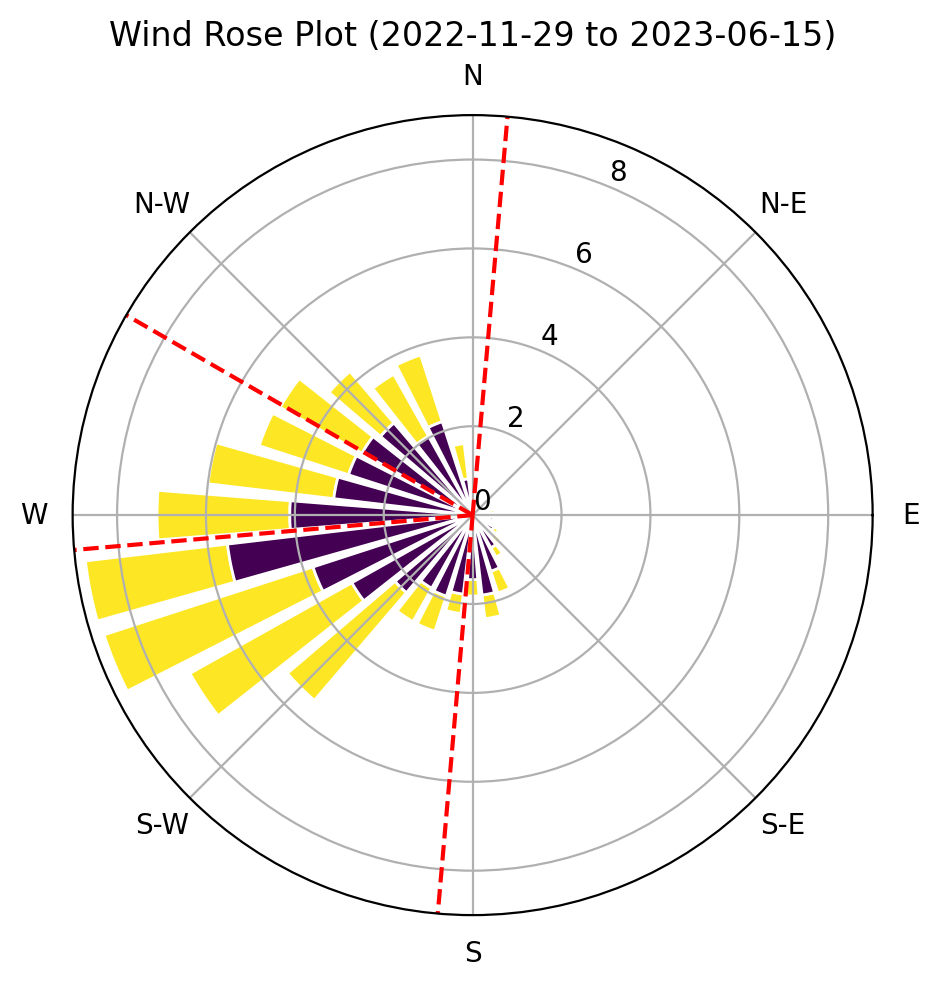

In [305]:
import matplotlib.pyplot as plt
from windrose import WindroseAxes
import numpy as np
# Create a wind rose plot
fig = plt.figure(figsize=(5,5), dpi=200) 
ax = WindroseAxes.from_ax(fig=fig)
wind_rose_src = synoptic_winds_30min.dropna()
ax.bar(
    synoptic_winds_30min['wind_direction'], synoptic_winds_30min['wind_speed'], 
    edgecolor='white', opening=0.8, 
    normed=True,
    nsector=32,
    # bins = np.arange(0, 31, 6)
    bins = np.arange(0, 20, 10)
)

# Add a line at theta = 299 degrees
# theta = np.deg2rad(-299 + 90)  # Convert degrees to radians
# ax.plot([np.deg2rad(-202 + 90), np.deg2rad(-202 + 90)], [0, 19], color='red', linestyle='--')
# ax.plot([np.deg2rad(-248 + 90), np.deg2rad(-248 + 90)], [0, 19], color='red', linestyle='--')
# ax.plot([np.deg2rad(-299 + 90), np.deg2rad(-299 + 90)], [0, 19], color='red', linestyle='--')
# ax.plot([np.deg2rad(-345 + 90), np.deg2rad(-345 + 90)], [0, 19], color='red', linestyle='--')
ax.plot([np.deg2rad(-185 + 90), np.deg2rad(-185 + 90)], [0, 19], color='red', linestyle='--')
ax.plot([np.deg2rad(-265 + 90), np.deg2rad(-265 + 90)], [0, 19], color='red', linestyle='--')
ax.plot([np.deg2rad(-300 + 90), np.deg2rad(-300 + 90)], [0, 19], color='red', linestyle='--')
ax.plot([np.deg2rad(-5 + 90), np.deg2rad(-5 + 90)], [0, 19], color='red', linestyle='--')

# Customize the plot
ax.set_title(f"Wind Rose Plot ({synoptic_winds_30min.index.min().date()} to {synoptic_winds_30min.index.max().date()})")
# ax.set_legend(title="Frequency (%)", loc='lower right')
ax.set_ylim(0,9)
ax.set_yticks(np.arange(0, 10, step=2))
ax.set_yticklabels(np.arange(0, 10, step=2))
# ax.set_xlim(0.5*np.pi,1.5*np.pi)
plt.show()

# Create synoptic wind speed/direction categories and save to files 

Speed categories

In [503]:
winds_ge10_times = synoptic_winds_30min [ synoptic_winds_30min.wind_speed > 10 ] 
winds_le10_times = synoptic_winds_30min [ synoptic_winds_30min.wind_speed <= 10 ] 

Direction categories

In [504]:
# along_valley_wind_times = synoptic_winds_30min[
#     (synoptic_winds_30min.wind_direction > 299)
#     & (synoptic_winds_30min.wind_direction < 345 )
# ].index.values
# cross_valley_wind_times = synoptic_winds_30min[
#     (synoptic_winds_30min.wind_direction > 202)
#     & (synoptic_winds_30min.wind_direction < 270 )
# ].index.values
# len(cross_valley_wind_times), len(along_valley_wind_times)


# Better option??
# 185-265, 
# 300 - 5

along_valley_wind_times = synoptic_winds_30min[
    (synoptic_winds_30min.wind_direction > 300)
    | (synoptic_winds_30min.wind_direction < 5 )
].index.values
cross_valley_wind_times = synoptic_winds_30min[
    (synoptic_winds_30min.wind_direction > 185)
    & (synoptic_winds_30min.wind_direction < 265 )
].index.values
print(len(synoptic_winds_30min), len(cross_valley_wind_times), len(along_valley_wind_times))
print("PERCENT OF DATA THAT FALLS INTO EITHER CATEGORY:")
print('\t',
    100 *  round((len(cross_valley_wind_times) + len(along_valley_wind_times)) / len(synoptic_winds_30min), 4)
)


9506 3636 1686
PERCENT OF DATA THAT FALLS INTO EITHER CATEGORY:
	 55.989999999999995


In [505]:
N_fast_cross_winds = len(set(winds_ge10_times.index).intersection(pd.to_datetime(cross_valley_wind_times)))
N_fast_along_winds = len(set(winds_ge10_times.index).intersection(pd.to_datetime(along_valley_wind_times)))
N_slow_cross_winds = len(set(winds_le10_times.index).intersection(pd.to_datetime(cross_valley_wind_times)))
N_slow_along_winds = len(set(winds_le10_times.index).intersection(pd.to_datetime(along_valley_wind_times)))

print(f"fast, cross valley winds, N = {N_fast_cross_winds}")
print(f"fast, along valley winds, N = {N_fast_along_winds}")
print(f"slow, cross valley winds, N = {N_slow_cross_winds}")
print(f"slow, along valley winds, N = {N_slow_along_winds}")

print(f"Percent of cross-valley winds that are fast, {round(100*N_fast_cross_winds / (N_fast_cross_winds + N_slow_cross_winds), 1)}")
print(f"Percent of along-valley winds that are fast, {round(100*N_fast_along_winds / (N_fast_along_winds + N_slow_along_winds), 1)}")

fast, cross valley winds, N = 1688
fast, along valley winds, N = 693
slow, cross valley winds, N = 1948
slow, along valley winds, N = 993
Percent of cross-valley winds that are fast, 46.4
Percent of along-valley winds that are fast, 41.1


In [506]:
cross_valley_wind_times = pd.Series(cross_valley_wind_times)
along_valley_wind_times = pd.Series(along_valley_wind_times)

In [507]:
cross_valley_wind_times.to_csv('cross_valley_wind_times.csv')
along_valley_wind_times.to_csv('along_valley_wind_times.csv')
pd.Series(winds_ge10_times.index).to_csv('winds_ge10_times.csv')
pd.Series(winds_le10_times.index).to_csv('winds_le10_times.csv')

# LOOK AT WIND PROFILES ON APRIL 18

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_92909/4000302717.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  src_rolling_mean = src.groupby('time').apply(


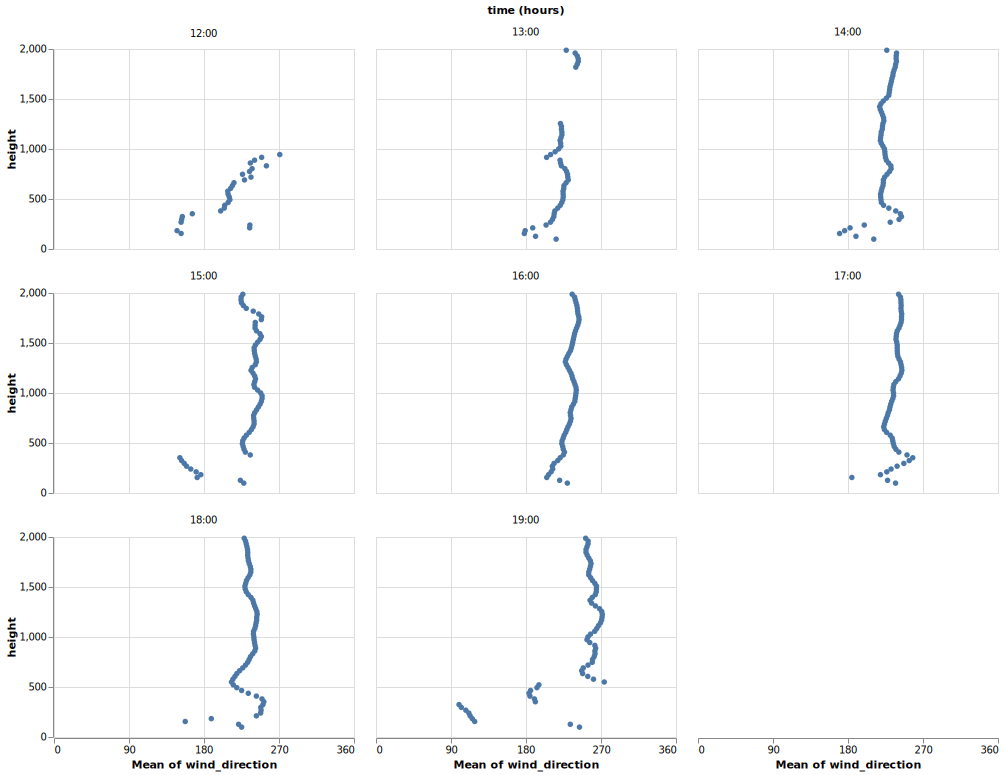

In [508]:
src = prof_df_localtime.loc['20230418 1200': '20230418 2000'].query("height < 2000")[['height','wind_speed', 'wind_direction', 'u', 'v']].reset_index()
src_rolling_mean = src.groupby('time').apply(
    lambda df: df.set_index('height')[['u', 'v']].rolling(4, center=True, min_periods=4).mean()
)
src_rolling_mean['wind_direction'] = np.rad2deg(np.arctan2(
    - src_rolling_mean['u'],
    - src_rolling_mean['v'],
))
src_rolling_mean.head()
src_rolling_mean['wind_direction'] = src_rolling_mean['wind_direction'].apply(lambda dir: dir if dir > 0 else dir + 360)

alt.Chart(src_rolling_mean.reset_index()).mark_circle(
    # point=True
).encode(
    alt.X('mean(wind_direction):Q').axis(values=[0,90,180,270,360]).scale(domain=[0,360]),
    alt.Y('height:Q'),
    alt.Facet('hours(time):O', columns=3),
    # alt.Color('minutes(time):O').scale(scheme='inferno'),
    order='height'
).properties(height=200)

# Examine synoptic wind statistics

In [509]:
synoptic_winds_pdf_data = pd.concat([
        synoptic_winds_30min[synoptic_winds_30min.index.isin(cross_valley_wind_times)].assign(synoptic_wind = 'cross valley'),
        synoptic_winds_30min[synoptic_winds_30min.index.isin(along_valley_wind_times)].assign(synoptic_wind = 'along valley')
    ])

<Axes: ylabel='Frequency'>

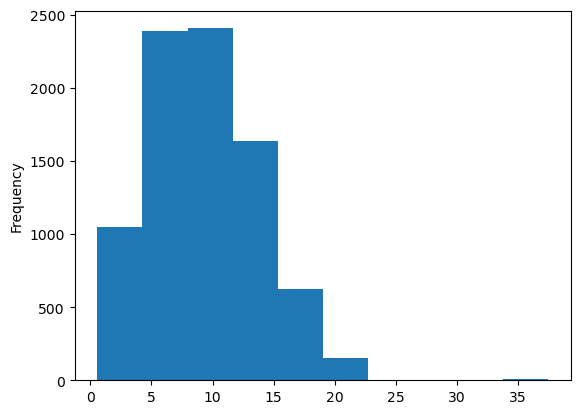

In [510]:
synoptic_winds_30min.wind_speed.plot.hist()

In [511]:
top_20_max_windspeed_days = synoptic_winds_pdf_data.groupby(pd.Grouper(freq='1d'))[['wind_speed']].max().sort_values('wind_speed', ascending=False).head(20).index
top_20_avg_windspeed_days = synoptic_winds_pdf_data.groupby(pd.Grouper(freq='1d'))[['wind_speed']].mean().sort_values('wind_speed', ascending=False).head(20).index

In [512]:
for datetime in top_20_max_windspeed_days:
    cross_cnt = len(cross_valley_wind_times[cross_valley_wind_times.dt.date == datetime.date()])
    along_cnt = len(along_valley_wind_times[along_valley_wind_times.dt.date == datetime.date()])
    if cross_cnt > along_cnt:
        print(datetime.date())
        print('cross', cross_cnt)
        print('along', along_cnt)
        print()

2023-03-04
cross 28
along 0

2023-04-04
cross 22
along 6

2023-03-22
cross 31
along 0

2023-02-22
cross 29
along 0

2023-04-03
cross 38
along 0

2023-03-08
cross 32
along 0

2022-12-02
cross 27
along 0

2023-02-05
cross 34
along 0

2022-12-01
cross 37
along 0

2023-01-29
cross 45
along 1

2022-12-05
cross 40
along 0

2023-03-06
cross 35
along 0

2023-03-05
cross 47
along 0

2023-04-18
cross 45
along 0

2023-02-19
cross 19
along 1

2023-02-24
cross 38
along 0



In [513]:
for datetime in top_20_avg_windspeed_days:
    cross_cnt = len(cross_valley_wind_times[cross_valley_wind_times.dt.date == datetime.date()])
    along_cnt = len(along_valley_wind_times[along_valley_wind_times.dt.date == datetime.date()])
    if cross_cnt > along_cnt:
        print(datetime.date())
        print('cross', cross_cnt)
        print('along', along_cnt)
        print()

2023-03-04
cross 28
along 0

2023-03-06
cross 35
along 0

2022-11-30
cross 14
along 0

2023-03-22
cross 31
along 0

2023-02-28
cross 18
along 0

2023-02-05
cross 34
along 0

2023-03-28
cross 19
along 0

2023-03-08
cross 32
along 0

2023-04-03
cross 38
along 0

2023-03-10
cross 38
along 0

2023-02-24
cross 38
along 0

2023-02-22
cross 29
along 0

2022-12-11
cross 31
along 0

2022-12-02
cross 27
along 0

2022-12-01
cross 37
along 0

2023-01-01
cross 24
along 0



In [514]:
top_12_windspeed_days = synoptic_winds_pdf_data.groupby(pd.Grouper(freq='1d')).max().sort_values('wind_speed', ascending=False).head(12).index
top_12_windspeed_days[0]
for dt in top_12_windspeed_days:
    print(len(cross_valley_wind_times[cross_valley_wind_times.dt.date == dt.date]))
    print(len(along_valley_wind_times[along_valley_wind_times.dt.date == dt.date]))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [515]:
synoptic_winds_pdf_data.index.min(), synoptic_winds_pdf_data.index.max()

(Timestamp('2022-11-30 13:30:00'), Timestamp('2023-06-15 17:30:00'))

In [516]:
synoptic_winds_pdf_data.groupby(pd.Grouper(freq='1d')).max().wind_speed.quantile(0.90)

19.6196044921875

In [517]:
synoptic_winds_pdf_data.synoptic_wind.value_counts()

synoptic_wind
cross valley    3636
along valley    1686
Name: count, dtype: int64

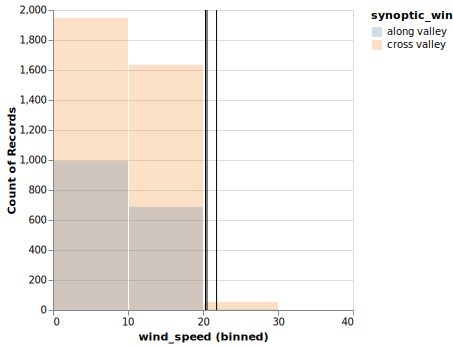

In [518]:
alt.Chart(synoptic_winds_pdf_data).mark_bar(opacity=0.25).encode(
    alt.X('wind_speed:Q').bin(step=10),
    alt.Y('count():Q', stack=False),
    color='synoptic_wind:N'
) + alt.Chart().mark_rule().encode(
    x=alt.datum(synoptic_winds_pdf_data.loc['20230306'].wind_speed.max())
) + alt.Chart().mark_rule().encode(
    x=alt.datum(synoptic_winds_pdf_data.loc['20230308'].wind_speed.max())
) + alt.Chart().mark_rule().encode(
    x=alt.datum(synoptic_winds_pdf_data.loc['20230418'].wind_speed.max())
)

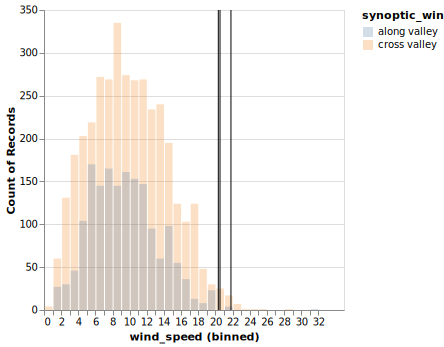

In [519]:
alt.Chart(synoptic_winds_pdf_data).mark_bar(opacity=0.25).encode(
    alt.X('wind_speed:Q').bin(step=1),
    alt.Y('count():Q', stack=False),
    color='synoptic_wind:N'
) + alt.Chart().mark_rule().encode(
    x=alt.datum(synoptic_winds_pdf_data.loc['20230306'].wind_speed.max())
) + alt.Chart().mark_rule().encode(
    x=alt.datum(synoptic_winds_pdf_data.loc['20230308'].wind_speed.max())
) + alt.Chart().mark_rule().encode(
    x=alt.datum(synoptic_winds_pdf_data.loc['20230418'].wind_speed.max())
)

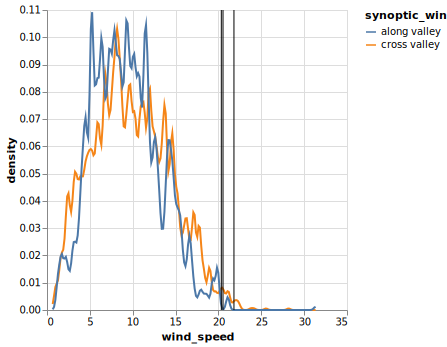

In [520]:
alt.Chart(synoptic_winds_pdf_data).transform_density(
    'wind_speed',
    as_=['wind_speed', 'density'],
    groupby = ['synoptic_wind'],
    bandwidth=0.2,
).mark_line().encode(
    x='wind_speed:Q',
    y='density:Q',
    color='synoptic_wind:N'
) + alt.Chart().mark_rule().encode(
    x=alt.datum(synoptic_winds_pdf_data.loc['20230306'].wind_speed.max())
) + alt.Chart().mark_rule().encode(
    x=alt.datum(synoptic_winds_pdf_data.loc['20230308'].wind_speed.max())
) + alt.Chart().mark_rule().encode(
    x=alt.datum(synoptic_winds_pdf_data.loc['20230418'].wind_speed.max())
)

# Examine vertical profiles of vertical velocity statistics, with doppler lidar (vertical staring)

In [521]:
# Inputs
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")
DATE_FORMAT_STR = '%Y-%m-%d'
DLW_DATA_STREAM = 'gucdlprofwstats4newsM1.c1'
DLW_DATA_STREAM_FILEEXT = '.cdf'
DLW_OUTPUT_DIR = os.path.join(data_dir, DLW_DATA_STREAM)

Download between start and end date

In [522]:
# file_list = act.discovery.download_arm_data(
#     username, token, DLW_DATA_STREAM, '20230409', '20230409', output = DLW_OUTPUT_DIR
# )

Or just open existing files between start and end date

In [523]:
files = glob.glob(os.path.join(DLW_OUTPUT_DIR, "*.nc"))
# Function to extract date from filename (adjust regex or slicing as needed)
def extract_date(filename):
    # Assuming filenames have a format like "data_YYYYMMDD.nc"
    basename = os.path.basename(filename)
    date_str = basename.split('gucdlprofwstats4newsM1.c1.')[1].split('.000000')[0]  # Adjust based on your filename format
    return date_str

# Filter files based on date range
file_list = [
    file for file in files
    if startdate.replace('-','') <= extract_date(file) <= enddate.replace('-','')
]

In [524]:
dl_wstats = xr.open_mfdataset(file_list)
dl_wstats = utils.modify_xarray_timezone(
    dl_wstats,
    'UTC',
    'US/Mountain'
)

In [525]:
dl_wstats.time.min(), dl_wstats.time.max()

(<xarray.DataArray 'time' ()> Size: 8B
 array('2022-11-29T17:00:00.000000000', dtype='datetime64[ns]'),
 <xarray.DataArray 'time' ()> Size: 8B
 array('2023-06-16T17:50:00.000000000', dtype='datetime64[ns]'))

In [526]:
df_wstats = dl_wstats[['w_variance', 'w_skewness', 'snr']].to_dataframe()
df_wstats = df_wstats[df_wstats.snr > 0.008]

In [527]:
df_wstats_30min = df_wstats.reset_index().set_index('time').groupby([pd.Grouper(freq='30min'), 'height']).mean().reset_index()
df_wstats_30min


,time,height,w_variance,w_skewness,snr,time (US/Mountain),time (UTC)
0,2022-11-29 17:00:00,15.0,0.000234,-0.379480,0.030390,2022-11-29 17:10:00,2022-11-30 00:10:00
1,2022-11-29 17:00:00,45.0,1.077502,-0.319172,0.851177,2022-11-29 17:10:00,2022-11-30 00:10:00
2,2022-11-29 17:00:00,75.0,0.555193,-0.303367,1.468834,2022-11-29 17:10:00,2022-11-30 00:10:00
3,2022-11-29 17:00:00,105.0,0.693679,-0.316026,1.532165,2022-11-29 17:10:00,2022-11-30 00:10:00
4,2022-11-29 17:00:00,135.0,0.888906,-0.538809,1.555035,2022-11-29 17:10:00,2022-11-30 00:10:00
...,...,...,...,...,...,...,...
396250,2023-06-16 11:00:00,975.0,0.449742,-0.020496,0.008096,2023-06-16 11:10:00,2023-06-16 17:10:00
396251,2023-06-16 11:00:00,1005.0,0.474351,0.093469,0.009534,2023-06-16 11:05:00,2023-06-16 17:05:00
396252,2023-06-16 11:00:00,1095.0,0.385041,-0.371343,0.008466,2023-06-16 11:05:00,2023-06-16 17:05:00
396253,2023-06-16 11:00:00,1125.0,0.378536,9.093227,0.009190,2023-06-16 11:05:00,2023-06-16 17:05:00


## Variance

In [528]:
df_wstats_along_valley = df_wstats_30min[df_wstats_30min.time.isin(along_valley_wind_times)].query("height < 2000").assign(synoptic_wind_direction = 'along-valley')
df_wstats_cross_valley = df_wstats_30min[df_wstats_30min.time.isin(cross_valley_wind_times)].query("height < 2000").assign(synoptic_wind_direction = 'cross-valley')

df_wstats_with_synoptic_conditions = pd.concat([
    df_wstats_along_valley[df_wstats_along_valley.time.isin(winds_ge10_times.index)].assign(synoptic_wind_speed = '> 10'),
    df_wstats_along_valley[df_wstats_along_valley.time.isin(winds_le10_times.index)].assign(synoptic_wind_speed = '<= 10'),
    df_wstats_cross_valley[df_wstats_cross_valley.time.isin(winds_ge10_times.index)].assign(synoptic_wind_speed = '> 10'),
    df_wstats_cross_valley[df_wstats_cross_valley.time.isin(winds_le10_times.index)].assign(synoptic_wind_speed = '<= 10')
])

#### Median plot for April 18

In [529]:
src = dl_wstats.sel(
    time = slice('20230418 0000', '20230419 0000')
).resample(
    time='30min'
).mean().sel(height = slice(0,2000)).to_dataframe().reset_index().set_index('time')
apr18_2000_2100_median_variance_profile_smooth = alt.Chart(
    src[src.snr > 0.008].loc['20230418 2000': '20230418 2059'].reset_index()
).mark_line(color='black').transform_window(
    rolling_avg = 'mean(w_variance)',
    frame=[-5,5],
    groupby=['time']
).encode(
    alt.X("mean(rolling_avg):Q").title("w'w'"),
    alt.Y('height:Q').axis(None),
    order='height:Q'
)
apr18_2000_2100_median_variance_profile = alt.Chart(
    src[src.snr > 0.008].loc['20230418 2000': '20230418 2059'].reset_index()
).mark_line(color='black', strokeDash=[2,2]).transform_window(
    rolling_avg = 'mean(w_variance)',
    frame=[-5,5],
    groupby=['time']
).encode(
    alt.X("mean(w_variance):Q").title("w'w'"),
    alt.Y('height:Q'),
    order='height:Q'
)

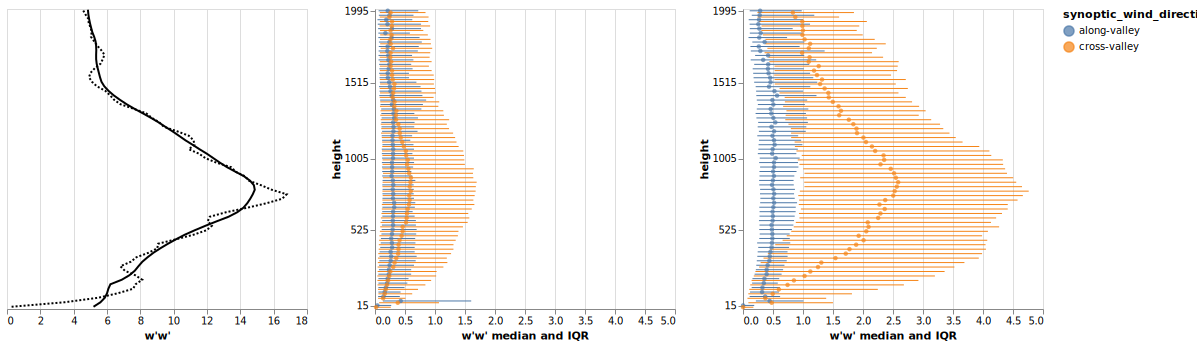

In [530]:
df_wvariance_stats = pd.concat([
    df_wstats_with_synoptic_conditions.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['w_variance'].quantile(0.25).rename('w_variance_lqr'),
    df_wstats_with_synoptic_conditions.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['w_variance'].quantile(0.75).rename('w_variance_uqr'),
    df_wstats_with_synoptic_conditions.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['w_variance'].median().rename('w_variance_median'),
], axis=1).reset_index()

plot_wvariance_iqr_slowwinds = alt.Chart(df_wvariance_stats.query("synoptic_wind_speed == '<= 10'")).mark_rule().encode(
        alt.X('w_variance_lqr:Q'),
        alt.X2('w_variance_uqr:Q'),
        alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300)
plot_wvariance_median_slowwinds = alt.Chart(df_wvariance_stats.query("synoptic_wind_speed == '<= 10'")).mark_circle(size=20).encode(
        alt.X('w_variance_median:Q').title("w'w' median and IQR"),
        alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300)
plot_wvariance_iqr_fastwinds = alt.Chart(df_wvariance_stats.query("synoptic_wind_speed == '> 10'")).mark_rule().encode(
        alt.X('w_variance_lqr:Q'),
        alt.X2('w_variance_uqr:Q'),
        alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300)
plot_wvariance_median_fastwinds = alt.Chart(df_wvariance_stats.query("synoptic_wind_speed == '> 10'")).mark_circle(size=20).encode(
        alt.X('w_variance_median:Q').title("w'w' median and IQR"),
        alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300)

(
    (apr18_2000_2100_median_variance_profile_smooth + apr18_2000_2100_median_variance_profile)
    | 
    (
        (plot_wvariance_iqr_slowwinds + plot_wvariance_median_slowwinds) 
        | 
        (plot_wvariance_iqr_fastwinds + plot_wvariance_median_fastwinds)
    ).resolve_scale(x='shared', y='shared', color='shared')
).resolve_scale(x='independent')

## Skewness

#### Median plot for April 18

In [531]:
src = dl_wstats.sel(
    time = slice('20230418 0000', '20230419 0000')
).resample(
    time='30min'
).mean().sel(height = slice(0,2000)).to_dataframe().reset_index().set_index('time')
src = src[src.snr > 0.008]

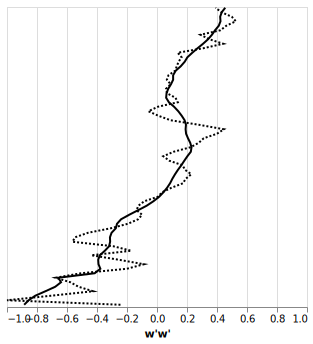

In [532]:
src = dl_wstats.sel(
    time = slice('20230418 0000', '20230419 0000')
).resample(
    time='30min'
).mean().sel(height = slice(0,2000)).to_dataframe().reset_index().set_index('time')
apr18_2000_2100_median_skewness_profile_smooth = alt.Chart(
    src[src.snr > 0.008].loc['20230418 2000': '20230418 2059'].reset_index()
).mark_line(color='black').transform_window(
    rolling_avg = 'mean(w_skewness)',
    frame=[-5,5],
    groupby=['time']
).encode(
    alt.X("mean(rolling_avg):Q").title("w'w'").scale(domain=[-1, 1], clamp=True),
    alt.Y('height:Q').axis(None),
    order='height:Q'
)
apr18_2000_2100_median_skewness_profile = alt.Chart(
    src[src.snr > 0.008].loc['20230418 2000': '20230418 2059'].reset_index()
).mark_line(color='black', strokeDash=[2,2]).transform_window(
    rolling_avg = 'mean(w_skewness)',
    frame=[-5,5],
    groupby=['time']
).encode(
    alt.X("mean(w_skewness):Q").title("w'w'"),
    alt.Y('height:Q'),
    order='height:Q'
)
apr18_2000_2100_median_skewness_profile_smooth + apr18_2000_2100_median_skewness_profile

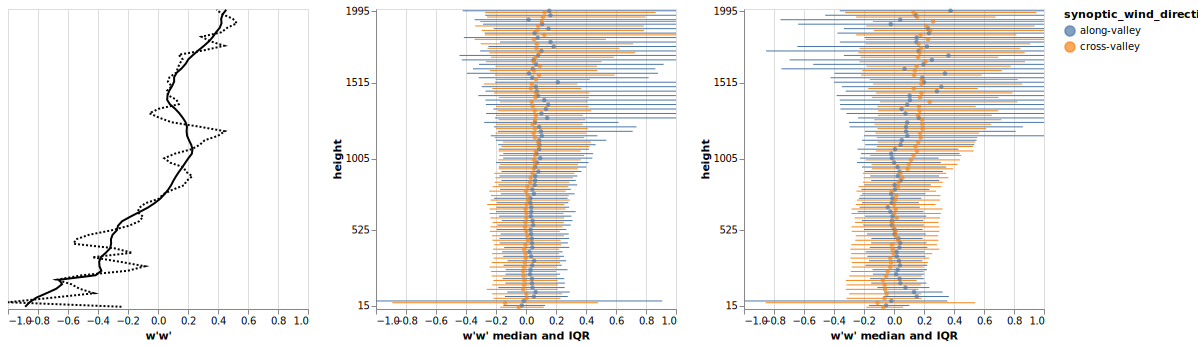

In [533]:
df_wskewness_stats = pd.concat([
    df_wstats_with_synoptic_conditions.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['w_skewness'].quantile(0.25).rename('w_skewness_lqr'),
    df_wstats_with_synoptic_conditions.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['w_skewness'].quantile(0.75).rename('w_skewness_uqr'),
    df_wstats_with_synoptic_conditions.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['w_skewness'].median().rename('w_skewness_median'),
], axis=1).reset_index()

plot_wskewness_iqr_slowwinds = alt.Chart(df_wskewness_stats.query("synoptic_wind_speed == '<= 10'")).mark_rule().encode(
        alt.X('w_skewness_lqr:Q').scale(domain=[-1, 1], clamp=True),
        alt.X2('w_skewness_uqr:Q'),
        alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300)
plot_wskewness_median_slowwinds = alt.Chart(df_wskewness_stats.query("synoptic_wind_speed == '<= 10'")).mark_circle(size=20).encode(
        alt.X('w_skewness_median:Q').title("w'w' median and IQR"),
        alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300)
plot_wskewness_iqr_fastwinds = alt.Chart(df_wskewness_stats.query("synoptic_wind_speed == '> 10'")).mark_rule().encode(
        alt.X('w_skewness_lqr:Q').scale(domain=[-1, 1], clamp=True),
        alt.X2('w_skewness_uqr:Q'),
        alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300)
plot_wskewness_median_fastwinds = alt.Chart(df_wskewness_stats.query("synoptic_wind_speed == '> 10'")).mark_circle(size=20).encode(
        alt.X('w_skewness_median:Q').title("w'w' median and IQR"),
        alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300)

(
    (apr18_2000_2100_median_skewness_profile_smooth + apr18_2000_2100_median_skewness_profile)
    | 
    (
        (plot_wskewness_iqr_slowwinds + plot_wskewness_median_slowwinds) 
        | 
        (plot_wskewness_iqr_fastwinds + plot_wskewness_median_fastwinds)
    ).resolve_scale(x='shared', y='shared', color='shared')
).resolve_scale(x='independent')

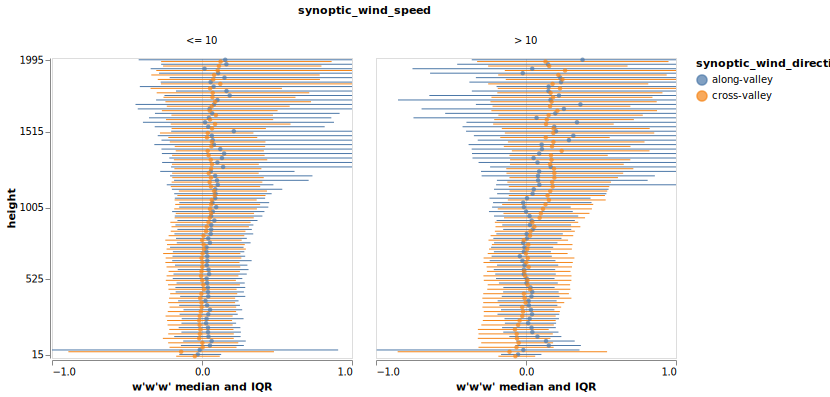

In [534]:
df_wskewness_stats = pd.concat([
    df_wstats_with_synoptic_conditions.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['w_skewness'].quantile(0.25).rename('w_skewness_lqr'),
    df_wstats_with_synoptic_conditions.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['w_skewness'].quantile(0.75).rename('w_skewness_uqr'),
    df_wstats_with_synoptic_conditions.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['w_skewness'].median().rename('w_skewness_median'),
], axis=1).reset_index()

(alt.Chart(df_wskewness_stats).mark_rule().encode(
    alt.X('w_skewness_lqr:Q').scale(domain=[-1, 1], clamp=True).axis(values=[-1,0,1]),
    alt.X2('w_skewness_uqr:Q'),
    alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
    alt.YOffset('synoptic_wind_direction:N'),
    alt.Color('synoptic_wind_direction'),
).properties(height=300) + alt.Chart(df_wskewness_stats).mark_circle(size=20).encode(
    alt.X('w_skewness_median:Q').scale(domain=[-1, 1], clamp=True).axis(values=[-1,0,1]).title("w'w'w' median and IQR"),
    alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
    alt.YOffset('synoptic_wind_direction:N'),
    alt.Color('synoptic_wind_direction'),
).properties(height=300)).facet(
    column = 'synoptic_wind_speed'
)
# apr18_2000_2100_median_skewness_profile_smooth
# apr18_2000_2100_median_skewness_profile

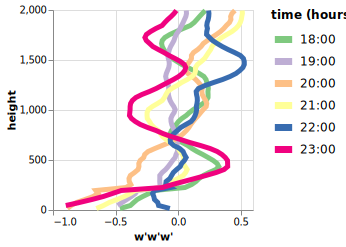

In [535]:
src = dl_wstats.sel(
    time = slice('20230418 0000', '20230419 0000')
).resample(
    time='30min'
).mean().sel(height = slice(0,2000)).to_dataframe().reset_index().set_index('time')
alt.Chart(
    src[src.snr > 0.008].loc['20230418 1800': '20230418 2359'].reset_index()
).mark_line(strokeWidth=5).transform_window(
    rolling_avg = 'mean(w_skewness)',
    frame=[-5,5],
    groupby=['time']
).encode(
    alt.X("mean(rolling_avg):Q").title("w'w'w'"),
    alt.Y('height:Q'),
    alt.Color('hours(time):O').scale(scheme='accent'),
    order='height:Q'
).configure_legend(
    titleFontSize=12,  # Adjust title font size
    labelFontSize=12,  # Adjust label font size
    symbolSize=300,
    symbolStrokeWidth=7   # Adjust symbol size
).properties(width=200, height=200).display(renderer='svg')

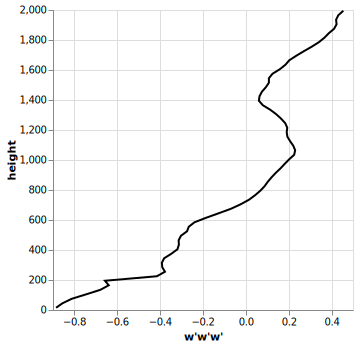

In [536]:
src = dl_wstats.sel(
    time = slice('20230418 0000', '20230419 0000')
).resample(
    time='30min'
).mean().sel(height = slice(0,2000)).to_dataframe().reset_index().set_index('time')
apr18_2000_2100_median_skewness_profile = alt.Chart(
    src[src.snr > 0.008].loc['20230418 2000': '20230418 2059'].reset_index()
).mark_line(color='black').transform_window(
    rolling_avg = 'mean(w_skewness)',
    frame=[-5,5],
    groupby=['time']
).encode(
    alt.X("mean(rolling_avg):Q").title("w'w'w'"),
    alt.Y('height:Q'),
    order='height:Q'
)
apr18_2000_2100_median_skewness_profile

Median plots with April 18 profiles

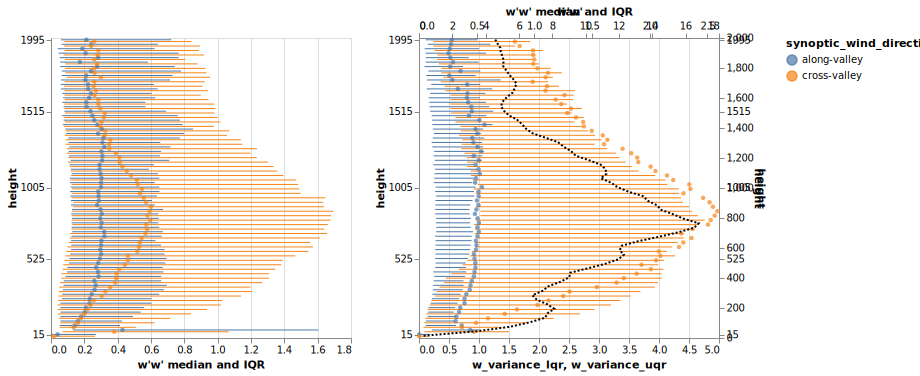

In [537]:
slow_wind_speed_median_variance_chart = (
    alt.Chart(df_wvariance_stats.query("synoptic_wind_speed == '<= 10'")).mark_rule().encode(
        alt.X('w_variance_lqr:Q'),
        alt.X2('w_variance_uqr:Q'),
        alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300) + 
    alt.Chart(df_wvariance_stats.query("synoptic_wind_speed == '<= 10'")).mark_circle(size=20).encode(
        alt.X('w_variance_median:Q').title("w'w' median and IQR"),
        alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300)
)

fast_wind_speed_median_variance_chart = (
    alt.Chart(df_wvariance_stats.query("synoptic_wind_speed == '> 10'")).mark_rule().encode(
        alt.X('w_variance_lqr:Q'),
        alt.X2('w_variance_uqr:Q'),
        alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300) + 
    alt.Chart(df_wvariance_stats.query("synoptic_wind_speed == '> 10'")).mark_circle(size=20).encode(
        alt.X('w_variance_median:Q').title("w'w' median and IQR"),
        alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300)
)
(
    slow_wind_speed_median_variance_chart 
    | (
        fast_wind_speed_median_variance_chart + apr18_2000_2100_median_variance_profile
    ).resolve_scale(x='independent')
).resolve_scale(x='shared', y='shared', color='shared')

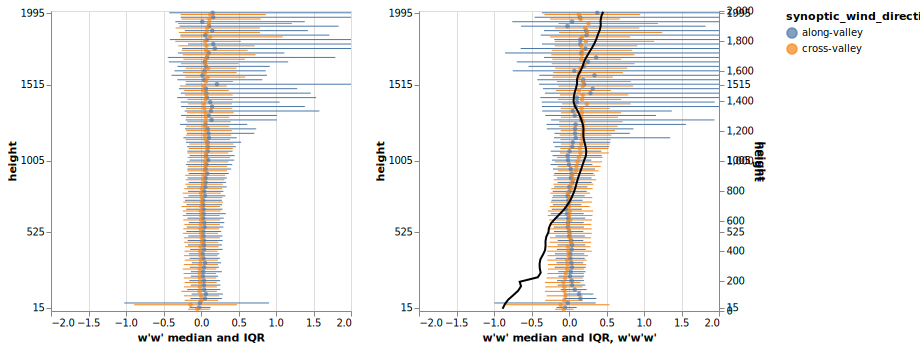

In [538]:
slow_wind_speed_median_skewness_chart = (
    alt.Chart(df_wskewness_stats.query("synoptic_wind_speed == '<= 10'")).mark_rule().encode(
        alt.X('w_skewness_lqr:Q').scale(domain=[-1.5, 1.5], clamp=True),
        alt.X2('w_skewness_uqr:Q'),
        alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300) + 
    alt.Chart(df_wskewness_stats.query("synoptic_wind_speed == '<= 10'")).mark_circle(size=20).encode(
        alt.X('w_skewness_median:Q').title("w'w' median and IQR"),
        alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300)
)

fast_wind_speed_median_skewness_chart = (
    alt.Chart(df_wskewness_stats.query("synoptic_wind_speed == '> 10'")).mark_rule().encode(
        alt.X('w_skewness_lqr:Q').scale(domain=[-1.5, 1.5], clamp=True),
        alt.X2('w_skewness_uqr:Q'),
        alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300) + 
    alt.Chart(df_wskewness_stats.query("synoptic_wind_speed == '> 10'")).mark_circle(size=20).encode(
        alt.X('w_skewness_median:Q').title("w'w' median and IQR"),
        alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300)
)
(
    slow_wind_speed_median_skewness_chart 
    | fast_wind_speed_median_skewness_chart + apr18_2000_2100_median_skewness_profile
).resolve_scale(x='shared', y='shared', color='shared')

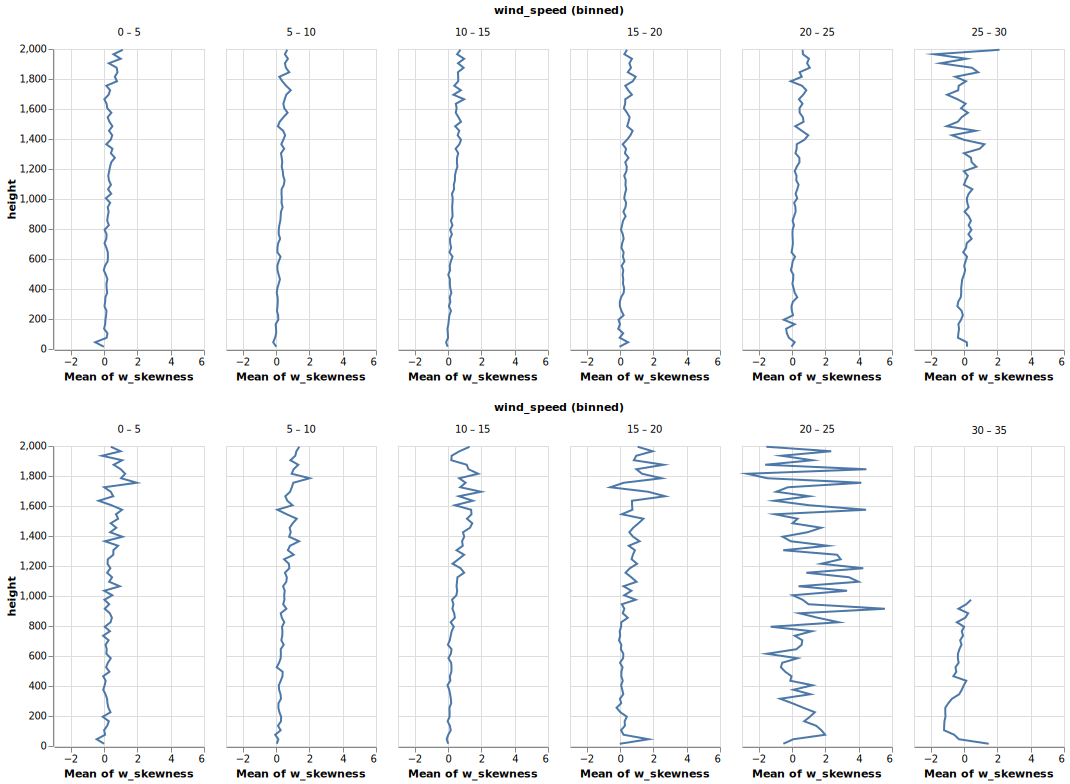

In [539]:
(alt.Chart(
    df_wstats_cross_valley.set_index('time').join(synoptic_winds_30min)
).mark_line().encode(
    alt.X('mean(w_skewness)'),
    alt.Y('height:Q'),
    alt.Facet('wind_speed').bin(),
    order='height'
).properties(width=150) & alt.Chart(
    df_wstats_along_valley.set_index('time').join(synoptic_winds_30min)
).mark_line().encode(
    alt.X('mean(w_skewness)'),
    alt.Y('height:Q'),
    alt.Facet('wind_speed').bin(),
    order='height'
).properties(width=150)).resolve_scale(y='shared', x='shared')

In [540]:
df_wskewness_stats = pd.concat([
    df_wstats_cross_valley_with_synoptic_wind_bins.groupby(['height', 'synoptic_wind_direction', 'wind_speed_bin'])['w_skewness'].quantile(0.25).rename('w_skewness_lqr'),
    df_wstats_cross_valley_with_synoptic_wind_bins.groupby(['height', 'synoptic_wind_direction', 'wind_speed_bin'])['w_skewness'].quantile(0.75).rename('w_skewness_uqr'),
    df_wstats_cross_valley_with_synoptic_wind_bins.groupby(['height', 'synoptic_wind_direction', 'wind_speed_bin'])['w_skewness'].mean().rename('w_skewness_mean'),
], axis=1).reset_index()

NameError: name 'df_wstats_cross_valley_with_synoptic_wind_bins' is not defined

In [ ]:
(alt.Chart(df_wskewness_stats).mark_rule().encode(
    alt.X('w_skewness_lqr:Q').scale(domain=[-1, 1], clamp=True).axis(values=[-1,0,1]),
    alt.X2('w_skewness_uqr:Q'),
    alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
    alt.YOffset('synoptic_wind_direction:N'),
    alt.Color('synoptic_wind_direction'),
).properties(height=300) + alt.Chart(df_wskewness_stats).mark_circle(size=20).encode(
    alt.X('w_skewness_mean:Q').scale(domain=[-1, 1], clamp=True).axis(values=[-1,0,1]),
    alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
    alt.YOffset('synoptic_wind_direction:N'),
    alt.Color('synoptic_wind_direction'),
).properties(height=300)).facet(
    column = 'wind_speed_bin'
)

# Compare wind direction shear and mixing intensity

In [ ]:
wprof_resampled_ds = prof_df_localtime.groupby([pd.Grouper(freq='30min'), 'height'])[['wind_speed', 'wind_direction']].mean().to_xarray()
wprof_resampled_df = wprof_resampled_ds.to_dataframe()
wprof_resampled_df_smooth = pd.DataFrame(
    wprof_resampled_df.groupby(level=0).wind_direction.apply(lambda x: x.rolling(window=3, min_periods=1).mean())
).droplevel(0).query("height < 2000")

In [ ]:
alt.Chart(wprof_resampled_df_smooth.loc['20230418 1500':'20230418 1800'].reset_index()).mark_line().encode(
    alt.X('wind_direction:Q'),
    alt.Y('height:Q'),
    alt.Facet('hoursminutes(time):O'),
    order='height'
).properties(width=100, height=200)

# Identify RHI scans during fast cross-valley winds

How many scans of this type exist??

For now, let's start with synoptic winds > 20 m/s

In [ ]:
# fastest_synoptic_wind_speeds = winds_ge10_times
fastest_synoptic_wind_speeds = synoptic_winds_30min [ synoptic_winds_30min.wind_speed > 18 ] 
fastest_synoptic_wind_speeds

,wind_speed,wind_direction
time,,
2022-11-30 00:30:00,20.928425,286.490753
2022-11-30 01:00:00,20.762840,279.487274
2022-11-30 01:30:00,20.229771,280.634766
2022-11-30 02:00:00,20.850491,286.421875
2022-11-30 02:30:00,22.029140,290.253540
...,...,...
2023-04-21 06:30:00,18.947187,314.882080
2023-04-21 07:00:00,18.685627,312.513062
2023-04-27 19:30:00,18.614531,294.249451


In [ ]:
times_with_fast_cross_valley_winds = pd.DataFrame(pd.Series(list(
    set(fastest_synoptic_wind_speeds.index).intersection(pd.to_datetime(cross_valley_wind_times))
)).sort_values())
rhi_scan_file_names = pd.DataFrame(pd.Series(
    glob.glob("/Users/elischwat/Development/data/sublimationofsnow/gucdlrhiM1.b1/gucdlrhiM1.b1.*.cdf")
))

In [ ]:
# add minutes so we the times overlap with the times of the scans
times_with_fast_cross_valley_winds[1] = times_with_fast_cross_valley_winds[0] + dt.timedelta(minutes=15)
times_with_fast_cross_valley_winds[2] = times_with_fast_cross_valley_winds[0] + dt.timedelta(minutes=18)
times_with_fast_cross_valley_winds = times_with_fast_cross_valley_winds.drop(columns=0)
times_with_fast_cross_valley_winds = times_with_fast_cross_valley_winds.melt()[['value']]

In [ ]:
rhi_scan_file_names[1] = rhi_scan_file_names[0].apply(lambda s : s.split('/gucdlrhiM1.b1.')[-1].split('.cdf')[0][:-2])

rhi_scan_file_names[2] = rhi_scan_file_names[1].apply(
    lambda s: dt.datetime(
        year = int(s[:4]),
        month = int(s[4:6]),
        day = int(s[6:8]),
        hour = int(s[9:11]),
        minute = int(s[11:13]),
    )
)

In [ ]:
scan_files_with_fast_cross_valley_winds = times_with_fast_cross_valley_winds.set_index('value').join(
    rhi_scan_file_names.set_index(2)
)[[0]].dropna()

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_92909/2526232642.py:1: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  scan_files_with_fast_cross_valley_winds = times_with_fast_cross_valley_winds.set_index('value').join(


In [ ]:
print(f"I have this many scans downloaded that are during fast, cross-valley winds: {len(scan_files_with_fast_cross_valley_winds)}")

I have this many scans downloaded that are during fast, cross-valley winds: 146


Plot and save all scans

In [ ]:
output_dir = './rhi_scans_during_fast_crossvalley_winds/'

In [ ]:
profile_ds = xr.open_dataset('profile.nc')

In [ ]:
for f in sorted(
    scan_files_with_fast_cross_valley_winds[0].values
):
    try: 
        ds = xr.open_dataset(f)
        ds['x'] = ds['range']*np.cos(np.deg2rad(ds['elevation']))
        ds['z'] = ds['range']*np.sin(np.deg2rad(ds['elevation']))
        ds['x'] = - ds['x']
        ds['SNR'] = ds['intensity'] - 1
        ds = ds.where(ds['SNR'] > 0.008)
        ds = ds.sel(range=slice(0,3000))
        plt.subplots(figsize=(9.6, 4))
        plt.contourf(
            ds['x'].values.T, ds['z'].values.T,
            ds['radial_velocity'].values,
            cmap='gist_ncar',
            levels=50
        )
        plt.fill_between(
            profile_ds.data.to_dataframe().index,
            -20,
            profile_ds.data.to_dataframe().data,
            color='grey'
        )
        plt.xlim(-2250,500)
        plt.ylim(0,2000)
        plt.colorbar()
        plt.gca().set_aspect('equal')
        name = f.split('gucdlrhiM1.b1/gucdlrhiM1.b1.')[1][:-4]
        plt.title(name)
        plt.savefig(os.path.join(output_dir, name + '.png'))
        plt.close()
    except Exception as exc:
        print(f'Failed on {f}')

Failed on /Users/elischwat/Development/data/sublimationofsnow/gucdlrhiM1.b1/gucdlrhiM1.b1.20230304.204834.cdf
